when I project the update, the new projefcted update needs to be passed to some modules.

However they have per-parameter states. Those states are often initialized with stuff like torch.zeros_like(param), but param is unprojected, so the shape will be wrong.

The easiest solution is to project params too, but that is an extra operation that is done for no reason.

Here is another idea, set params to the projected update.

So suppose I have a projection module. On first step it would project the update and initialize children to that update as parameters. That means children must not be initialized until the first step.

This is better, but there is an issue - 1st update just stays there in memory as parameters. Deleting it after each step is complicated - `modules` might have a nested structure.

Issue - update doesn't require grad. Typically params with requires_grad = None are skipped. This can be fixed by using `b = a.view_as(a).requires_grad_(True)`, as that `a` remains with requires_grad=False.

To delete it, we can create a hook that sets the storage of the projected update to an empty tensor. However some modules might store previous update, which will have the same storage. However `set_` doesn't change the storage itself, it changes the tensor to have a different storage, so it works.

In [ ]:
import torchzero as tz
import torch
from functools import partial

@torch.no_grad
def _delete_params_hook(opt: tz.core.Modular, vars: tz.core.Vars, proj_module: tz.core.Module):
    assert len(proj_module.param_groups) == 1
    for p in proj_module.param_groups[0]['params']:
        p.set_(torch.empty(0, device=p.device, dtype=p.dtype))


class FFTProject(tz.core.Module):
    def __init__(self, *modules: tz.core.Chainable):
        super().__init__()

        self.set_child('modules', tz.utils.flatten(modules))
        self.current_step = 0

    def initialize_child_params(self, key: str):
        pass
        # do nothing, children remain uninitialized

    @torch.no_grad
    def step(self, vars):
        params = self.get_params()
        update = vars.get_update(params)

        # project
        projected_update = (update.map(torch.fft.rfftn)).view_as_real()

        fft_module = self.children['modules']

        # initialize children on 1st step
        if self.current_step == 0:
            assert len(fft_module.param_groups) == 0
            fft_module._initialize((t.view_as(t).requires_grad_() for t in projected_update))

        # re-set parameters to new projected update storage (they are still the same object so states work!)
        else:
            assert len(fft_module.param_groups) == 1
            for p, u in zip(fft_module.param_groups[0]['params'], projected_update):
                p.set_(u.view_as(u).requires_grad_())

        # step in projected space
        vars.update = projected_update
        fft_module.step(vars)

        # unproject
        unprojected_update = tz.utils.TensorList(torch.fft.irfftn(torch.view_as_complex(u)) for u in vars.update)
        vars.update = unprojected_update
        self.current_step += 1

        # add hook to clean memory
        vars.post_step_hooks.append(partial(_delete_params_hook, proj_module = fft_module))

        return vars

In [26]:
a = torch.tensor([1.,2.,3.,4.])
b = a.view((2,2))

a.untyped_storage().data_ptr() == b.untyped_storage().data_ptr()

True

finished in 0.2s., reached loss = 0.00199                                      


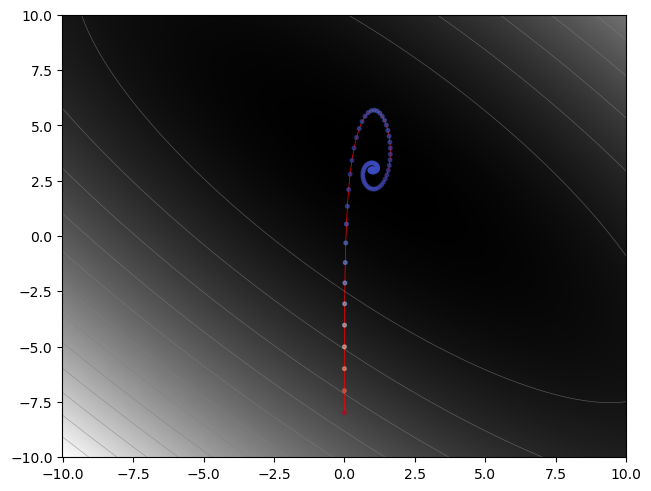

In [10]:
import visualbench as vb

b = vb.FunctionDescent('booth')
opt = tz.Modular(b.parameters(), FFTProject(tz.m.Adam()), tz.m.LR(1))
b.run(opt, 200)
b.plot()

finished in 0.2s., reached loss = 6.359                                      


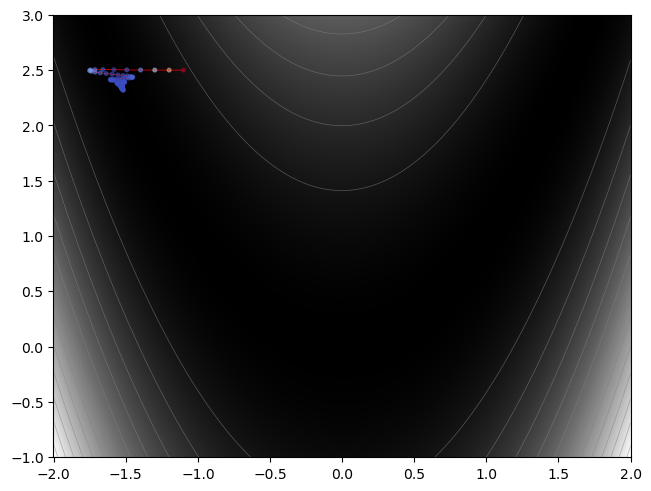

In [4]:
import visualbench as vb

b = vb.FunctionDescent('rosen')
opt = tz.Modular(b.parameters(), FFTProject(tz.m.Adam()), tz.m.LR(1))
b.run(opt, 200)
b.plot()

In [ ]:
class Avg2(tz.core.Transform):
    def transform(self, target, vars):
        prev = self.state_vals('prev')
        res = target + prev
        prev.set_(target)

        # so this returns res, but `prev` shares storage with `target`
        # could this create issues?
        return res

# a potential Sum module would pass cloned vars.
# target might be `grad`. Then further modules with same target may modify it in-place
# this is an extremely specific case and doesn't need fixing (it is sort of expected too).
# so no further modules should have any effect on `prev`/`update` storage in this case.
# but `Projection` will empty it and then un-empty before next step and set to new update.
# which is not ideal.

# NEW API